In [1]:
# importacao das bibliotecas

import keras
import numpy
import matplotlib.pyplot as plt
import pandas
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
%matplotlib inline
plt.style.use('classic')

In [2]:
# banco de dados [1] — http://dx.doi.org/10.1016/j.fuel.2012.03.010

# o banco de dados [1] foi tratado para prover resultados da viscosidade do sistema quimico
# SiO2-Al2O3-Fe2O3-FeO-CaO-MgO-Na2O-K2O-MnO-TiO2-P2O5-NiO-CaF2-SO3-Cr2O3-V2O5
# medidos experimentalmente atraves do metodo 'rotacional', intermediado por viscosimetros
# (ou reometros) rotacionais.
# O metodo rotacional e o mais utilizado na medicao experimental [2] — https://doi.org/10.1016/S0360-1285(00)00023-X

In [ ]:
# realizar upload:
# banco de dados — dados_rede_materia.csv
# arquivo exemplo — dados_rede_materia_exemplo.csv SE NECESSARIO
# rede neural — modelo_treinado_materia.h5

from google.colab import files
files.upload()

In [4]:
# nome do arquivo do banco de dados pos analise e pre-processamento do banco de dados
arquivo = 'dados_rede_materia.csv'

In [5]:
# visualizacao do banco de dados
pandas.read_csv(arquivo, delimiter=';')

,SiO2,Al2O3,Fe2O3,FeO,CaO,MgO,Na2O,K2O,MnO,TiO2,P2O5,NiO,CaF2,SO3,Cr2O3,V2O5,T,N
0,0.709430,0.000000,0.0,0.000000,0.290570,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1973.0,1.360000
1,0.709430,0.000000,0.0,0.000000,0.290570,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023.0,1.040000
2,0.709430,0.000000,0.0,0.000000,0.290570,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2073.0,0.850000
3,0.669447,0.000000,0.0,0.000000,0.330553,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1923.0,1.000000
4,0.669447,0.000000,0.0,0.000000,0.330553,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1973.0,0.780000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424,0.399979,0.199979,0.0,0.050055,0.150006,0.199981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1583.0,18.197009
3425,0.399979,0.199979,0.0,0.050055,0.150006,0.199981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,11.246050
3426,0.399979,0.199979,0.0,0.050055,0.150006,0.199981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1630.0,6.165950
3427,0.399979,0.199979,0.0,0.050055,0.150006,0.199981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1678.0,2.978516


In [6]:
# tratamento de dados

In [8]:
# calculo do NBO/T [3] — http://dx.doi.org/10.2355/isijinternational.ISIJINT-2015-364
# parametro de despolimerizacao
# considera os valores de (des)polimerizacao por monomeros, dimeros, cadeias, placas e/ou redes
# quao maior o NBO/T, menor a viscosidade. O inverso e verdadeiro

# renomear o cabecalho
colRename = {0:'SiO2', 1:'Al2O3', 2:'Fe2O3', 3:'FeO', 4:'CaO', 5:'MgO',
6:'Na2O', 7:'K2O', 8:'MnO', 9:'TiO2', 10:'P2O5', 11:'NiO',
12:'CaF2', 13:'SO3', 14:'Cr2O3', 15:'V2O5'}

# leitura de dados
dados = pandas.read_csv(arquivo, delimiter=';')
dados = dados.drop(['N', 'T'], axis=1)

# mol/g de cada especie quimica
cao, sio2, al2o3, mgo = 56.0774, 72.1704, 101.9612, 40.3044
tio2, mno, feo, caf2 = 79.8658, 70.9374, 71.8444, 78.0748
na2o, k2o = 54.9886, 94.1960
fe2o3, p2o5, nio =  199.5608, 191.944, 74.6928
cr2o3, v2o5, so3 = 151.99, 181.88, 80.06

# conversao de g para mol
dados['CaO'], dados['SiO2'] = dados['CaO']/cao, dados['SiO2']/sio2
dados['Al2O3'], dados['MgO'] = dados['Al2O3']/al2o3, dados['MgO']/mgo
dados['TiO2'], dados['MnO'] = dados['TiO2']/tio2, dados['MnO']/mno
dados['FeO'], dados['CaF2'] = dados['FeO']/feo, dados['CaF2']/caf2
dados['Na2O'] = dados['Na2O']/na2o
dados['K2O'] = dados['K2O']/k2o
dados['Fe2O3'] = dados['Fe2O3']/fe2o3
dados['P2O5'], dados['NiO'] = dados['P2O5']/p2o5, dados['NiO']/nio
dados['Cr2O3'] = dados['Cr2O3']/cr2o3
dados['V2O5'] = dados['V2O5']/v2o5
dados['SO3'] = dados['SO3']/so3
dados = dados.values

# normalizacao de valores (para somar 100)
a1 = []
for i in range(0, len(dados)):
    a1 = a1 + [dados[i].sum()]
    for j in range(0, len(dados[i])):
        dados[i][j] = dados[i][j]/ a1[i]

# readaptacao os dados
dados = pandas.DataFrame(dados)
dados = dados.rename(columns = colRename)

# calculo do NBO/T
nbot = 2*(dados['CaO'] + dados['MgO'] + dados['MnO'] + dados['FeO'] + dados['NiO']\
          + dados['Na2O'] + dados['K2O'] \
          - (dados['Al2O3'] + dados['Fe2O3'] + dados['Cr2O3'])) / \
          (dados['SiO2'] + dados['TiO2']\
           - 2*(dados['Al2O3'] + dados['Fe2O3'] + dados['Cr2O3']))
pandas.DataFrame(nbot, columns=['NBO/T'])

,NBO/T
0,1.054247
1,1.054247
2,1.054247
3,1.270941
4,1.270941
...,...
3424,7.869294
3425,7.869294
3426,7.869294
3427,7.869294


In [9]:
# calculo do Tliq [3] — http://dx.doi.org/10.2355/isijinternational.ISIJINT-2015-364
# temperatura liquidus — temperatura onde, acima dela, a escoria esta totalmente liquida
# (OU temperatura maxima onde liquido e solido coexistem)

# leitura dos dados
dados = pandas.read_csv(arquivo, delimiter=';')
dados = dados.drop(['N', 'T'], axis=1).values

# normalizacao
a1 = []
for i in range(0, len(dados)):
    a1 = a1 + [dados[i].sum()]
    for j in range(0, len(dados[i])):
        dados[i][j] = dados[i][j]/ a1[i]

# readaptacao dos dados
dados = pandas.DataFrame(dados)
dados = dados.rename(columns = colRename)
dados = 100*dados

# calculo do Tliq (K)
tliq = 1473 + 2.59*(dados['CaO'] + (1-(38/78))*dados['CaF2']) - 1.518*dados['SiO2'] - 1.51*dados['Al2O3'] \
- 11.71*dados['MgO'] - 9.06*dados['Na2O'] - 6*dados['K2O'] \
- 9.87*dados['FeO'] - 2.12*dados['MnO'] + 4.8*(dados['CaF2']*(38/78))
pandas.DataFrame(tliq, columns=['Tliq'])

,Tliq
0,1440.566106
1,1440.566106
2,1440.566106
3,1456.991043
4,1456.991043
...,...
3424,1137.356026
3425,1137.356026
3426,1137.356026
3427,1137.356026


In [10]:
# normalizacao da composicao quimica final

# leitura de dados
dados = pandas.read_csv(arquivo, delimiter=';')
dados_N = pandas.DataFrame(dados['N'])
dados_T = pandas.DataFrame(dados['T'])
dados = dados.drop(['N', 'T'], axis=1).values

# normalizacao
a1 = []
for i in range(0, len(dados)):
    a1 = a1 + [dados[i].sum()]
    for j in range(0, len(dados[i])):
        dados[i][j] = dados[i][j]/ a1[i]

# readaptacao dos dados
dados = pandas.DataFrame(dados)
dados = pandas.concat([dados.round(4), dados_T, dados_N], axis=1)
dados = dados.rename(columns = colRename)
pandas.DataFrame(dados)

,SiO2,Al2O3,Fe2O3,FeO,CaO,MgO,Na2O,K2O,MnO,TiO2,P2O5,NiO,CaF2,SO3,Cr2O3,V2O5,T,N
0,0.7094,0.0,0.0,0.0000,0.2906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1973.0,1.360000
1,0.7094,0.0,0.0,0.0000,0.2906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023.0,1.040000
2,0.7094,0.0,0.0,0.0000,0.2906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2073.0,0.850000
3,0.6694,0.0,0.0,0.0000,0.3306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1923.0,1.000000
4,0.6694,0.0,0.0,0.0000,0.3306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1973.0,0.780000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424,0.4000,0.2,0.0,0.0501,0.1500,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1583.0,18.197009
3425,0.4000,0.2,0.0,0.0501,0.1500,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,11.246050
3426,0.4000,0.2,0.0,0.0501,0.1500,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1630.0,6.165950
3427,0.4000,0.2,0.0,0.0501,0.1500,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1678.0,2.978516


In [11]:
# introduzir colunas no banco de dados e refinamento

# insercao de colunas no banco de dados
dados.insert(loc = len(dados.columns)-1, column = 'Tliq',
value = tliq, allow_duplicates = False)

dados.insert(loc = len(dados.columns)-1, column = 'NBO/T',
value = nbot, allow_duplicates = False)

# refinamento de polimerizacao
dados = dados[dados['NBO/T'] > -200]

# conversao de viscosidade
dados['N'] = numpy.log(dados['N'])
dados = dados[dados['N'] < numpy.log(10**12)]

# refinamento para escorias 100% liquidas
dados = dados[dados['T'] > dados['Tliq']]

# retirada de duplicatas
dados.drop_duplicates(keep = False, inplace = True)

# visualizacao do banco de dados apos a analise de dados
dados

,SiO2,Al2O3,Fe2O3,FeO,CaO,MgO,Na2O,K2O,MnO,TiO2,P2O5,NiO,CaF2,SO3,Cr2O3,V2O5,T,Tliq,NBO/T,N
0,0.7094,0.0,0.0,0.0000,0.2906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1973.0,1440.566106,1.054247,0.307485
1,0.7094,0.0,0.0,0.0000,0.2906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023.0,1440.566106,1.054247,0.039221
2,0.7094,0.0,0.0,0.0000,0.2906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2073.0,1440.566106,1.054247,-0.162519
3,0.6694,0.0,0.0,0.0000,0.3306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1923.0,1456.991043,1.270941,0.000000
4,0.6694,0.0,0.0,0.0000,0.3306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1973.0,1456.991043,1.270941,-0.248461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424,0.4000,0.2,0.0,0.0501,0.1500,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1583.0,1137.356026,7.869294,2.901257
3425,0.4000,0.2,0.0,0.0501,0.1500,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,1137.356026,7.869294,2.420017
3426,0.4000,0.2,0.0,0.0501,0.1500,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1630.0,1137.356026,7.869294,1.819042
3427,0.4000,0.2,0.0,0.0501,0.1500,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1678.0,1137.356026,7.869294,1.091425


In [12]:
# padronizacao dos dados de entrada
x_total = dados.iloc[0:len(dados), 0:len(dados.columns) - 1]
x_banco_dados = x_total
y_total = dados.iloc[0:len(dados), len(dados.columns) - 1:len(dados.columns)]

# visualizacao das variaveis independentes do banco de dados apos a analise de dados
# (composicao quimica, temperatura, temperatura liquidus e NBO/T)
x_banco_dados

,SiO2,Al2O3,Fe2O3,FeO,CaO,MgO,Na2O,K2O,MnO,TiO2,P2O5,NiO,CaF2,SO3,Cr2O3,V2O5,T,Tliq,NBO/T
0,0.7094,0.0,0.0,0.0000,0.2906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1973.0,1440.566106,1.054247
1,0.7094,0.0,0.0,0.0000,0.2906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023.0,1440.566106,1.054247
2,0.7094,0.0,0.0,0.0000,0.2906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2073.0,1440.566106,1.054247
3,0.6694,0.0,0.0,0.0000,0.3306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1923.0,1456.991043,1.270941
4,0.6694,0.0,0.0,0.0000,0.3306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1973.0,1456.991043,1.270941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424,0.4000,0.2,0.0,0.0501,0.1500,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1583.0,1137.356026,7.869294
3425,0.4000,0.2,0.0,0.0501,0.1500,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,1137.356026,7.869294
3426,0.4000,0.2,0.0,0.0501,0.1500,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1630.0,1137.356026,7.869294
3427,0.4000,0.2,0.0,0.0501,0.1500,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1678.0,1137.356026,7.869294


In [13]:
# visualizacao da variavel dependente (viscosidade) do banco de dados apos a analise de dados
numpy.exp(y_total)

,N
0,1.360000
1,1.040000
2,0.850000
3,1.000000
4,0.780000
...,...
3424,18.197009
3425,11.246050
3426,6.165950
3427,2.978516


In [15]:
# padronizacao
x_total = (x_total - x_total.mean()) / x_total.std()

# particao de dados de treinamento e de teste
x, xt, y, yt = train_test_split(x_total, y_total, test_size = 0.1, random_state = 3)

# construcao e treinamento da rede OU carregar a rede

# SE escolha == 1 sera construida a rede neural com as especificacoes na codificacao
# SE NAO, sera carregada a rede feita no 'files.upload()'

escolha = 'carregar_rede'

if escolha == 1:

    # implementacao com os dados completos de cada camada

    # camada de entrada
    camada_entrada = keras.layers.Input(shape = (len(x.columns), ), name = 'camada_de_entrada')

    # camada oculta
    neuronios_co = 190  # numero de neuronios na camada oculta
    camada_oculta = keras.layers.Dense(units = neuronios_1, activation = 'selu', use_bias = True, name = 'camada_oculta',
    kernel_initializer = 'lecun_uniform', bias_initializer = 'zeros')(camada_entrada)

    # camada saida
    camada_saida = keras.layers.Dense(units = 1, activation = 'linear', use_bias = True, name = 'camada_de_saida',
    kernel_initializer = 'he_uniform', bias_initializer = 'zeros')(camada_oculta)

    # construcao do modelo
    modelo = keras.models.Model(inputs = [camada_entrada], outputs = [camada_saida], name = 'modelo_viscosidade')

    # a juncao da rede, com cada hyperparametro
    otimizador = keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.99, epsilon = 0.000001, amsgrad = False)
    modelo.compile(optimizer = otimizador, loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

    # a formulacao do treino da rede
    passos, batch_size = 200000, 64
    chamada = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = passos/2,
    verbose = 1, mode = 'auto', baseline = None, restore_best_weights = True)
    modeloFeito = modelo.fit(x, y, validation_split = 0.1,  epochs = passos,
    batch_size = batch_size, callbacks = [chamada], verbose = 1)

    # salvando a rede
    modelo.save('modelo_treinado_materia.h5')

else:

    # carregar a rede
    modelo = keras.models.load_model('modelo_treinado_materia.h5')

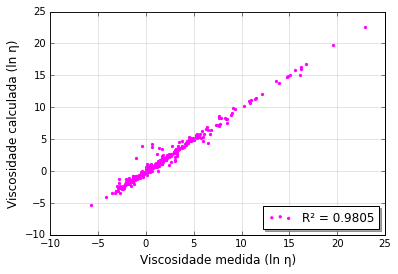

In [17]:
# grafico correlacionando os valores medidos (abscissas) e calculados (ordenadas)

# valores gerados no grafico. SE:
# TESTE — x_grafico = xt e y_grafico = yt
# TREINAMENTO — x_grafico = x e y_grafico = y
# BANCO DE DADOS TOTAL — x_grafico = x_total e y_grafico = y_total
x_grafico = xt
y_grafico = yt

plt.scatter(x = y_grafico, y = modelo.predict(x_grafico),
label = f'R² = {round(r2_score(y_grafico, modelo.predict(x_grafico)), 4)}',
marker = '.', color = 'fuchsia')
plt.xlabel('Viscosidade medida (ln η)', size = 12)
plt.ylabel('Viscosidade calculada (ln η)', size = 12)
plt.legend(loc = 'lower right', shadow = True)
plt.grid(alpha = 0.2, color = 'grey', linewidth = 1, linestyle = '-')
plt.show()

In [18]:
# valor de erro absoluto médio e desvio padrão

# valores gerados no grafico. SE:
# TESTE — x_avaliacao = xt e y_avaliacao = yt
# TREINAMENTO — x_avaliacao = x e y_avaliacao = y
# BANCO DE DADOS TOTAL — x_avaliacao = x_total e y_avaliacao = y_total
x_avaliacao = xt
y_avaliacao = yt

print(f'O erro absoluto médio é {round(modelo.evaluate(x_avaliacao, y_avaliacao)[1], 4)} ln η (η in Pa.s)')
print(f'O desvio padrão é {round(abs(modelo.predict(x_avaliacao)-y_avaliacao).std()[0], 4)} ln η (η in Pa.s)')

11/11 [==============================] - 0s 2ms/step - loss: 0.3403 - mean_absolute_error: 0.3145
O erro absoluto médio é 0.3145ln η (η in Pa.s)
O desvio padrão é 0.4921ln η (η in Pa.s)


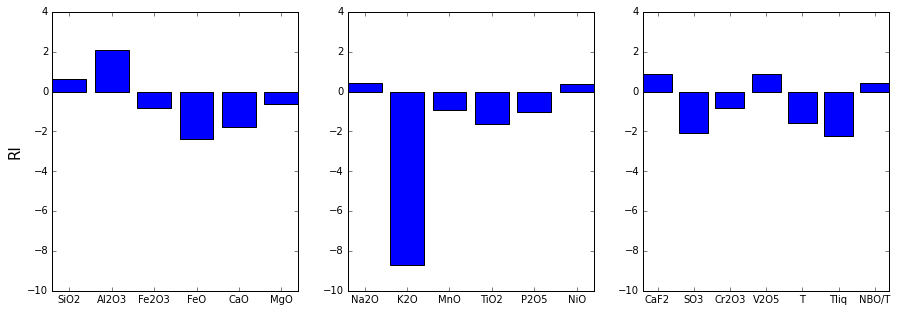

In [20]:
# leitura dos pesos ENTRADA-CAMADA_OCULTA e CAMADA_OCULTA_SAIDA

if escolha == 1:

    # leitura dos pesos da ENTRADA-CAMADA_OCULTA
    pesos_E_O=[]
    for i in range(0, len(x.columns)):
        pesos_E_O = pesos_E_O + [modelo.weights[0][i]]

    # leitura dos pesos da CAMADA_OCULTA_SAIDA
    pesos_O_S=[]
    for i in range(0, neuronios_co):
        pesos_O_S = pesos_O_S + [modelo.weights[2][i]]

else:

    # numero de neuronios da camada oculta da rede carregada
    neuronios_co=190

    # leitura dos pesos da ENTRADA-CAMADA_OCULTA
    pesos_E_O=[]
    for i in range(0, len(x.columns)):
        pesos_E_O = pesos_E_O + [modelo.weights[0][i]]
    
    # leitura dos pesos da CAMADA_OCULTA_SAIDA
    pesos_O_S=[]
    for i in range(0, neuronios_co):
        pesos_O_S = pesos_O_S + [modelo.weights[2][i]]

# analise de sensibilidade pelo método Connection Weights [4] — https://doi.org/10.1016/S0304-3800(02)00064-9
# SE a variavel X qualquer possuir a importancia relativa negativa, indica que quão maior a variavel, menor a viscosidade
# o contrario e verdadeiro. Quao maior a importancia relativa, maior o impacto

def c_w(A, B):
    "A função c_w retorna os valores de importância relativa de cada dado de entrada na rede neural construída"
    return numpy.dot(A, B)

# funcao para calcular as importancias relativas de cada entrada da rede neural
valores = c_w(pesos_E_O, pesos_O_S)

# grafico da analise de sensibilidade
# por exemplo, a variavel T (temperatura) tem importancia relativa negativa a viscosidade (RI(adimensional) = -1,5672),
# denotando que a temperatura influencia negativamente a viscosidade, sendo consonante com a literatura

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.bar(['SiO2', 'Al2O3', 'Fe2O3', 'FeO', 'CaO', 'MgO'], list(valores.reshape(-1,19)[0][0:6]))
plt.ylim(-10,4)  # igualar a escala dos graficos
plt.ylabel('RI', fontsize=15)

plt.subplot(132)
plt.bar(['Na2O', 'K2O', 'MnO', 'TiO2', 'P2O5', 'NiO'], list(valores.reshape(-1,19)[0][6:12]))
plt.ylim(-10,4)  # igualar a escala dos graficos

plt.subplot(133)
plt.bar(['CaF2', 'SO3', 'Cr2O3', 'V2O5', 'T', 'Tliq', 'NBO/T'], list(valores.reshape(-1,19)[0][12:19]))
plt.ylim(-10,4)  # igualar a escala dos graficos

plt.show()

In [21]:
# limites da rede em relacao ao banco de dados
# possui numero de dados, media, desvio padrao, minimo, primeiro, segundo e terceiro quartis e maximo da variavel
dados.describe()

,SiO2,Al2O3,Fe2O3,FeO,CaO,MgO,Na2O,K2O,MnO,TiO2,P2O5,NiO,CaF2,SO3,Cr2O3,V2O5,T,Tliq,NBO/T,N
count,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000,3365.000000
mean,0.482638,0.151069,0.060026,0.041421,0.167105,0.024948,0.024350,0.007870,0.018720,0.016073,0.000478,0.000114,0.003486,0.000547,0.000314,0.000834,1737.713857,1320.630622,2.127869,1.878568
std,0.177042,0.133522,0.141805,0.129567,0.141604,0.064884,0.060212,0.038559,0.084283,0.066836,0.002000,0.000933,0.019869,0.002034,0.002803,0.006169,180.236617,159.065887,12.014778,4.063622
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1152.000000,633.914724,-173.441852,-6.214608
25%,0.365100,0.000000,0.000000,0.000000,0.033400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1625.000000,1268.882778,0.000000,-0.918731
50%,0.480200,0.176000,0.000000,0.000000,0.143700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1723.000000,1357.090930,0.987149,1.102938
75%,0.617400,0.234700,0.055400,0.000000,0.265800,0.016300,0.008000,0.000100,0.000000,0.000200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1823.000000,1417.748589,3.203586,3.569533
max,1.000000,1.000000,0.851000,0.834900,0.590400,0.555800,0.357900,0.480000,0.722500,0.499900,0.041100,0.011700,0.178000,0.020200,0.034300,0.071800,2755.000000,1569.255745,218.878419,25.687639


In [ ]:
# simulacao  da rede neural

In [ ]:
#@title — 💻 - 🧮 🔥
arquivo = "" #@param {type:"string"}

arquivo = arquivo + '.csv'

files.upload()

try:

    # nome do arquivo a se fazer as predicoes da rede SE NECESSARIO

    # SE simulacao == 'sim' DEVE SER feito o carregamento do arquivo 'dados_rede_materia_exemplo.csv' em 'files.upload()
    # SE NAO, nada sera realizado

    # tratamento de dados para os valores independentes da rede
    # (mesmo tratamento de dados em relacao ao banco de dados)

    colRename = {0:'SiO2', 1:'Al2O3', 2:'Fe2O3', 3:'FeO', 4:'CaO', 5:'MgO',
    6:'Na2O', 7:'K2O', 8:'MnO', 9:'TiO2', 10:'P2O5', 11:'NiO',
    12:'CaF2', 13:'SO3', 14:'Cr2O3', 15:'V2O5'}

    dados = pandas.read_csv(arquivo, delimiter=';')
    dados = dados.drop(['T'], axis=1)

    cao, sio2, al2o3, mgo = 56.0774, 72.1704, 101.9612, 40.3044
    tio2, mno, feo, caf2 = 79.8658, 70.9374, 71.8444, 78.0748
    na2o, k2o = 54.9886, 94.1960
    fe2o3, p2o5, nio =  199.5608, 191.944, 74.6928
    cr2o3, v2o5, so3 = 151.99, 181.88, 80.06

    dados['CaO'], dados['SiO2'] = dados['CaO']/cao, dados['SiO2']/sio2
    dados['Al2O3'], dados['MgO'] = dados['Al2O3']/al2o3, dados['MgO']/mgo
    dados['TiO2'], dados['MnO'] = dados['TiO2']/tio2, dados['MnO']/mno
    dados['FeO'], dados['CaF2'] = dados['FeO']/feo, dados['CaF2']/caf2
    dados['Na2O'] = dados['Na2O']/na2o
    dados['K2O'] = dados['K2O']/k2o
    dados['Fe2O3'] = dados['Fe2O3']/fe2o3
    dados['P2O5'], dados['NiO'] = dados['P2O5']/p2o5, dados['NiO']/nio
    dados['Cr2O3'] = dados['Cr2O3']/cr2o3
    dados['V2O5'] = dados['V2O5']/v2o5
    dados['SO3'] = dados['SO3']/so3

    dados = dados.values

    a1 = []
    for i in range(0, len(dados)):
        a1 = a1 + [dados[i].sum()]
        for j in range(0, len(dados[i])):
            dados[i][j] = dados[i][j]/ a1[i]

    dados = pandas.DataFrame(dados)
    dados = dados.rename(columns = colRename)

    nbot = 2*(dados['CaO'] + dados['MgO'] + dados['MnO'] + dados['FeO'] + dados['NiO']\
    + dados['Na2O'] + dados['K2O'] \
    - (dados['Al2O3'] + dados['Fe2O3'] + dados['Cr2O3'])) / \
    (dados['SiO2'] + dados['TiO2']\
    - 2*(dados['Al2O3'] + dados['Fe2O3'] + dados['Cr2O3']))

    dados = pandas.read_csv(arquivo, delimiter=';')
    dados = dados.drop(['T'], axis=1).values

    a1 = []
    for i in range(0, len(dados)):
        a1 = a1 + [dados[i].sum()]
        for j in range(0, len(dados[i])):
            dados[i][j] = dados[i][j]/ a1[i]

    dados = pandas.DataFrame(dados)
    dados = dados.rename(columns = colRename)
    dados = 100*dados

    tliq = 1473 + 2.59*(dados['CaO'] + (1-(38/78))*dados['CaF2']) - 1.518*dados['SiO2'] - 1.51*dados['Al2O3'] \
    - 11.71*dados['MgO'] - 9.06*dados['Na2O'] - 6*dados['K2O'] \
    - 9.87*dados['FeO'] - 2.12*dados['MnO'] + 4.8*(dados['CaF2']*(38/78))

    dados = pandas.read_csv(arquivo, delimiter=';')
    dados_T = pandas.DataFrame(dados['T'])
    dados = dados.drop(['T'], axis=1).values

    a1 = []
    for i in range(0, len(dados)):
        a1 = a1 + [dados[i].sum()]
        for j in range(0, len(dados[i])):
            dados[i][j] = dados[i][j]/ a1[i]

    dados = pandas.DataFrame(dados)
    dados = pandas.concat([dados.round(4), dados_T,], axis=1)
    dados = dados.rename(columns = colRename)

    dados.insert(loc = len(dados.columns), column = 'Tliq',
    value = tliq, allow_duplicates = False)

    dados.insert(loc = len(dados.columns), column = 'NBO/T',
    value = nbot, allow_duplicates = False)

    dados = (dados - x_banco_dados.mean()) / x_banco_dados.std()

    # resultado final da rede, correlacionando a composicao quimica com a viscosidade (Pa.s)
    # do sistema quimico, na dada temperatura (K). O arquivo e 'resultados_rede.csv'

    resultados = pandas.concat([round(pandas.read_csv(arquivo, delimiter=';'), 4),
    round(pandas.DataFrame(numpy.exp(modelo.predict(dados))), 4)], axis=1)
    resultados = resultados.rename(columns = {0:'N'})

    resultados.to_csv('resultados_rede.csv')
    files.download('resultados_rede.csv')

except FileNotFoundError:

    print('')
    print('Não foi nomeado o arquivo/Nenhum arquivo foi selecionado.')

In [ ]:
'''
Referencias

[1] Marc A. Duchesne, Arne M. Bronsch, Robin W. Hughes, Patrick J. Masset.
Slag viscosity modeling toolbox.
Fuel. v. 114, p. 38-43, 2013.

[2] S. Vargas, F.J. Frandsen, K. Dam-Johansen.
Rheological properties of high-temperature melts of coal ashes and other silicates.
Progress in Energy and Combustion Science. v. 27, p. 237-429, 2001.

[3] Mills, K.C., Karagadde, S., Lee, P.D., Yuan, L., Shahbazian, F.
Calculation of Physical Properties for Use in Models of Continuous Casting Process Part 1 Mould Slags.
ISIJ International. v. 56. n. 2, p. 264-273, 2016.

[4] Olden, J., Jackson, D.
Illuminating the "black box": a randomization approach for understanding variable contributions in artificial neural networks.
Ecological Modelling. v. 154, p. 135–150, 2002.'''